In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print(np.array(resized_arr, dtype=object).shape)
    #print(len(resized_arr))
    return np.array(data, dtype=object)

In [ ]:
train = get_training_data('/content/drive/MyDrive/New')
test = get_training_data('/content/drive/MyDrive/Input/test')
val = get_training_data('/content/drive/MyDrive/Input/val')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


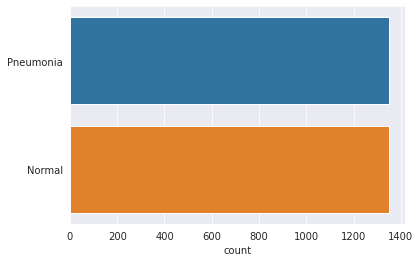

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(y = l)

Text(0.5, 1.0, 'NORMAL')

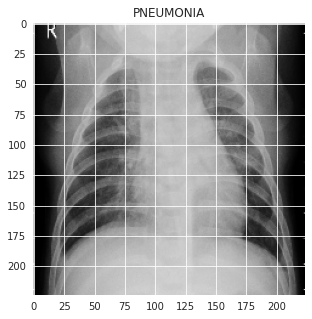

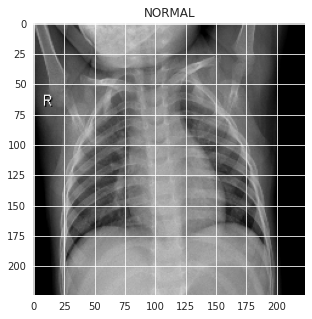

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

datagen = ImageDataGenerator(
        featurewise_center = False,  # Set Input Mean to 0 over the Dataset
        samplewise_center = False,  # Set each Sample Mean to 0
        featurewise_std_normalization = False,  # Divide Inputs by Std of the Dataset
        samplewise_std_normalization = False,  # Divide each Input by its std
        zca_whitening = False,  # Apply ZCA Whitening
        rotation_range = 30,  # Randomly rotate Images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom Image 
        width_shift_range = 0.1,  # Randomly shift Images horizontally (fraction of total width)
        height_shift_range = 0.1,  # Randomly shift Images vertically (fraction of total height)
        horizontal_flip = True,  # Randomly horizontal flip images
        vertical_flip = False)  # Randomly vertical flip images


datagen.fit(x_train)


In [ ]:
from keras.applications import ResNet50

feature_extractor = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)

feature_extractor.trainable = False

input_ = tensorflow.keras.Input(shape=(224, 224, 3))

x = feature_extractor(input_, training=False)

x = tensorflow.keras.layers.GlobalMaxPool2D()(x)

output_ = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)

model = tensorflow.keras.Model(input_, output_)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)
print(len(x_train))
print(len(y_train))

2698
2698


In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32), epochs = 30 , validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/30
85/85 [==============================] - 45s 392ms/step - loss: 0.6550 - accuracy: 0.6179 - val_loss: 0.5683 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
85/85 [==============================] - 31s 366ms/step - loss: 0.5652 - accuracy: 0.7113 - val_loss: 0.5817 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/30
85/85 [==============================] - 31s 368ms/step - loss: 0.5362 - accuracy: 0.7513 - val_loss: 0.4664 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/30
85/85 [==============================] - 31s 369ms/step - loss: 0.5117 - accuracy: 0.7602 - val_loss: 0.5773 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
85/85 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7839
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
85/85 [==============================] - 31s 368ms/step - loss: 0.4863 - accuracy: 0.7839 - val_loss: 0.5423 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/30
85/85 [==============================] - 32s 370ms

In [ ]:
print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, '%')
#model.save('/content/drive/MyDrive/Colab Notebooks/Custom')

20/20 [==============================] - 3s 144ms/step - loss: 0.4728 - accuracy: 0.8082
Loss of the model is -  0.47277721762657166
20/20 [==============================] - 2s 111ms/step - loss: 0.4728 - accuracy: 0.8082
Accuracy of the model is -  80.81761002540588 %


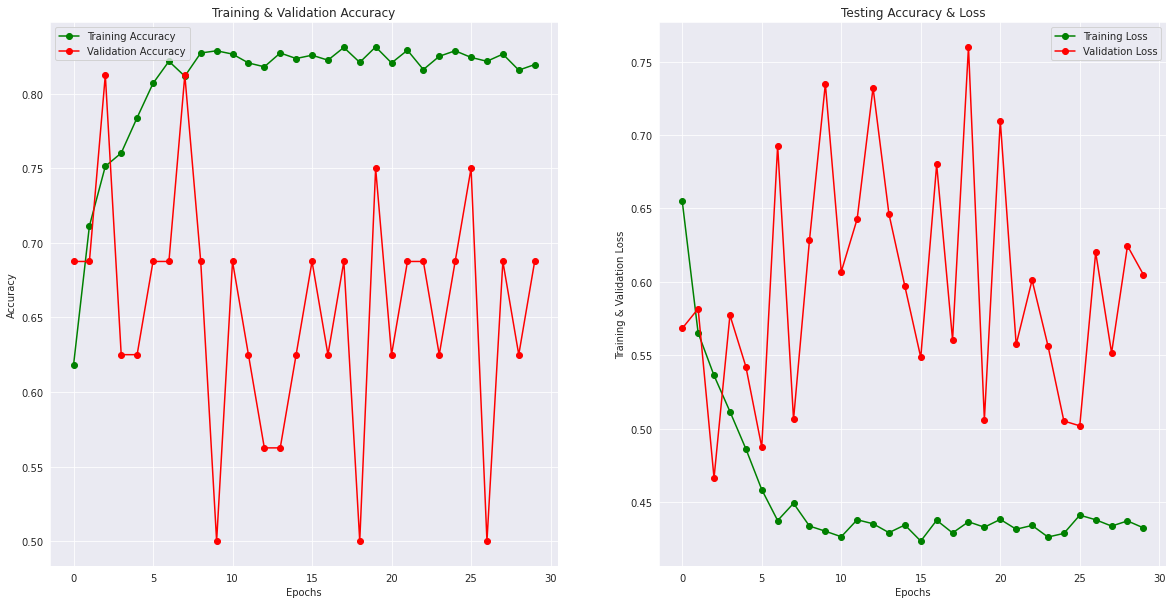

In [ ]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

20/20 [==============================] - 3s 95ms/step


array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.82      0.84       402
   Normal (Class 1)       0.72      0.79      0.75       234

           accuracy                           0.81       636
          macro avg       0.79      0.81      0.80       636
       weighted avg       0.81      0.81      0.81       636



In [ ]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[328  74]
 [ 48 186]]


In [ ]:
cm = pd.DataFrame(cm , index = ['0', '1'], columns = ['0', '1'])

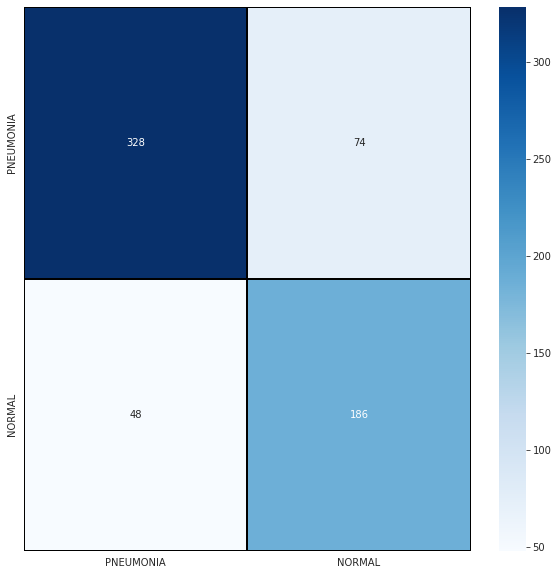

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

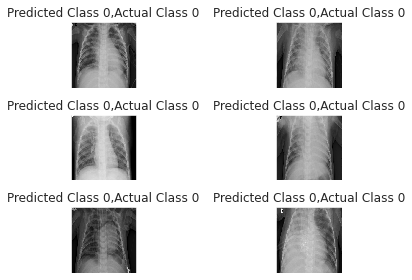

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224, 224, 3), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

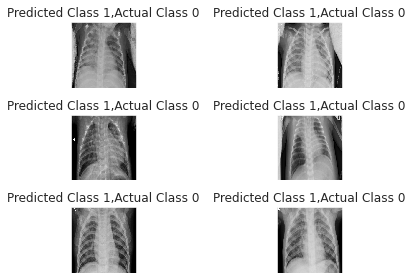

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224, 224, 3), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1